# Camera

## Location

We use a right-handed spherical coordinate system for camera positioning. In the following figure, the camera is positioned at:

- Longitude: 30 degrees
  - Rotated counterclockwise from the x-axis toward the y-axis
- Latitude: 40 degrees
  - Raised from the x-y plane toward the z-axis

The camera position is determined through a two-step transformation:

1. First, rotate 30 degrees counterclockwise from the x-axis in the x-y plane
2. Then, elevate 40 degrees from that position toward the z-axis

This coordinate system allows for intuitive camera positioning:

- Longitude controls the horizontal rotation around the scene
- Latitude controls the vertical angle from the ground plane


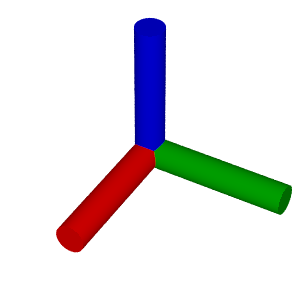

In [1]:
from fdray import *

Scene(
    Camera(longitude=30, latitude=40),
    LightSource(0, Color("white")),  # at camera location
    Cylinder(0, (1, 0, 0), 0.1, Color("red")),
    Cylinder(0, (0, 1, 0), 0.1, Color("green")),
    Cylinder(0, (0, 0, 1), 0.1, Color("blue")),
).render(width=300, height=300)

The camera implementation is based on the following Qiita article

 - Title: Efficient Camera Settings in POV-Ray
 - Author: @Hyrodium (Yuto Horikawa)
 - URL: https://qiita.com/Hyrodium/items/af91b1ddb8ea2c4359c2
 - Date: 2017-12-07


## View scale

### Overview

The `view_scale` parameter controls how much of the scene is visible in the rendered image. It functions similarly to adjusting a camera's field of view.


In [73]:
def scene(view_scale: float):
    return Scene(
        Camera(0, 0, view_scale=view_scale),
        LightSource(0, Color("white")),
        Cylinder("-y", "y", 0.2, Color("green")),
        Cylinder("-2*y", "2*y", 0.15, Color("green")),
        Cylinder("-3*y", "3*y", 0.1, Color("green")),
        Cylinder("-z", "z", 0.2, Color("blue")),
        Cylinder("-2*z", "2*z", 0.15, Color("blue")),
        Cylinder("-3*z", "3*z", 0.1, Color("blue")),
        Background(Color("gray")),
    ).render(width=200, height=200)



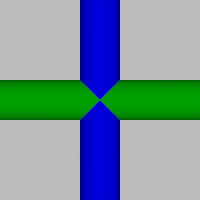
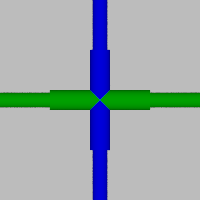
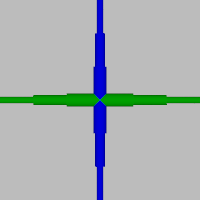

In [74]:
from IPython.display import HTML

from fdray.utils.html import to_html_horizontal

images = [scene(1), scene(2), scene(3)]
HTML(to_html_horizontal(images))

### Basic Operation

- A larger view scale shows more of the scene by "zooming out"
- A smaller view scale shows less of the scene by "zooming in"

### Technical Implementation

- The coordinate range rendered extends from `-view_scale` to `+view_scale`
- Directly affects the apparent size of objects in the scene
- Controls the viewing frustum without changing camera position

### Parameter Relationships

- Independent of camera position and orientation (longitude, latitude)
- Works in conjunction with the camera's distance parameter

## Distance

### Overview

The `distance` parameter controls the camera's perspective effect by adjusting the camera's position relative to the object's center. This parameter significantly affects how the 3D scene is rendered, particularly the perspective distortion.


In [75]:
def scene(distance: float):
    return Scene(
        Camera(15, 10, view_scale=2, distance=distance),
        LightSource((1, 20, 40), Color("white")),
        Box(-1, 1, Color("green", 0.8)),
        Background(Color("gray", 0.2)),
    ).render(width=200, height=200)



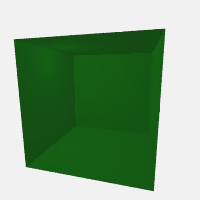
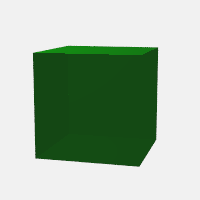
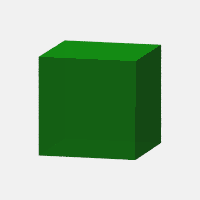

In [76]:
images = [scene(3), scene(10), scene(300)]
HTML(to_html_horizontal(images))

### Visual Effects

#### When distance is small:

- Creates a fisheye lens-like effect
- Produces strong perspective distortion
- Objects appear more curved at the edges
- Similar to viewing through a wide-angle lens

#### When distance is large:

- Approaches orthogonal projection
- Reduces perspective distortion
- Creates a more natural depth perception
- Similar to viewing through a telephoto lens

### Technical Details

The `distance` parameter:

- Affects the perspective matrix calculation
- Does not change the actual size of objects, only their apparent perspective

### Important Notes

- The `distance` parameter only affects perspective, not object size
- Smaller distances create more dramatic perspective effects
- Larger distances create more natural, less distorted views
- The effect is similar to changing the focal length of a camera lens

## Orbital Location

Calculate a position in orbit around the camera's location

Imagine tilting your head up (`angle`) and then rotating
counter-clockwise (`rotation`):

- First, move `forward` along viewing direction (0: at `camera.location`,
  1: at `camera.look_at`). Negative values move behind the camera.
- Then, tilt up from viewing direction by `angle` degrees
- Finally, rotate counter-clockwise from up by `rotation` degrees
    (0: up, 90: left, 180: down, 270: right)

In [2]:
def render(camera: Camera, *args):
    return Scene(
        camera,
        LightSource(0, "white"),
        Cylinder(0, "2*x", 0.02, Color("red")),
        Cylinder(0, "2*y", 0.02, Color("green")),
        Cylinder(0, "2*z", 0.02, Color("blue")),
        *args,
    ).render(width=400, height=400)

<0, 2, 0>
<2.2111, 0.89443, 0>


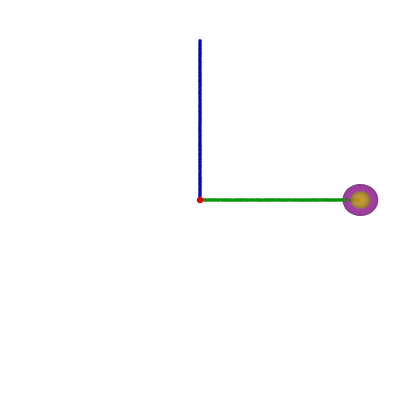

In [ ]:
from math import asin, degrees, sqrt

distance = 4
camera = Camera(0, 0, view_scale=2.5, look_at=(0, 0, 0), distance=distance)
norm = sqrt(distance**2 + 2**2)
angle = degrees(asin(2 / norm))
p1 = camera.orbital_location(norm / distance, angle, -90)
s1 = Sphere(p1, 0.2, Color("purple", 0.5))
p2 = camera.orbital_location(0.5, angle, -90)
s2 = Sphere(p2, 0.05, Color("orange", 0.5))
print(p1)
print(p2)
render(camera, s1, s2)

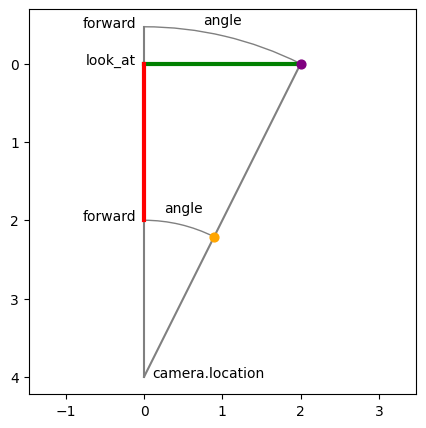

In [65]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot([2, 0], [0, distance], c="gray")
ax.plot([0, 0], [distance, distance - norm], c="gray")
ax.add_patch(
    Arc(
        (0, distance),
        2 * norm,
        2 * norm,
        theta1=270,
        theta2=270 + angle,
        color="gray",
    ),
)
ax.add_patch(
    Arc(
        (0, distance),
        distance,
        distance,
        theta1=270,
        theta2=270 + angle,
        color="gray",
    ),
)
ax.plot([0, 2], [0, 0], c="green", lw=3)
ax.plot([0, 0], [0, 2], c="red", lw=3)
ax.scatter([p1.y], [p1.x], c="purple", zorder=100, s=40)
ax.scatter([p2.y], [p2.x], c="orange", zorder=100, s=40)
ax.text(0.1, distance, "camera.location")
ax.text(-0.1, 0, "look_at", ha="right")
ax.text(-0.1, distance - norm, "forward", ha="right")
ax.text(-0.1, distance / 2, "forward", ha="right")
ax.text(1, -0.5, "angle", ha="center")
ax.text(0.5, 1.9, "angle", ha="center")
ax.invert_yaxis()
ax.axis("equal");